# Self-driving Car Project 5: Vehicle Detection and Tracking
The goals / steps of this project are the following:

* To train a classifier on images corresponding to vehicles using spatial feature, color histogram features, and HOG features.

* Implementing a sliding-window technique and use the trained classifier in searching for vehicles in images.

* Run the pipeline on a video stream of the 'advance lane line project' and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

* Estimate a bounding box over the heat-map for vehicles detected.




In [5]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.transform import resize
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from collections import deque
from moviepy.editor import VideoFileClip
import glob
import time


%matplotlib inline

In [6]:
class FeatureExtractor(object):
    """
    Helps extracting features from an image in regions.
    """

    def __init__(self, image, orient=10, pix_per_cell=8, cell_per_block=2):
        """
        Initialises an instance.
        Parameters
        ----------
        image           : Image to extract features from.
        orient          : HoG orientations.
        pix_per_cell    : HoG pixels per cell.
        cell_per_block  : HoG cells per block.
        """
        self.image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        (self.h, self.w, self.d) = self.image.shape
        self.hog_features = []
        self.pix_per_cell = pix_per_cell
        for channel in range(self.d):
            self.hog_features.append(
                hog(self.image[:, :, channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                    cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True,
                    visualise=False, feature_vector=False)
            )
        self.hog_features = np.asarray(self.hog_features)

    def hog(self, x, y, k):
        """
        Gets HoG features for specified region of the image.
        Parameters
        ----------
        x   : Image X coordinate.
        y   : Image Y coordinate.
        k   : Region size (single value, side of a square region).
        """
        hog_k = (k // self.pix_per_cell) - 1
        hog_x = max((x // self.pix_per_cell) - 1, 0)
        hog_x = self.hog_features.shape[2] - hog_k if hog_x + hog_k > self.hog_features.shape[2] else hog_x
        hog_y = max((y // self.pix_per_cell) - 1, 0)
        hog_y = self.hog_features.shape[1] - hog_k if hog_y + hog_k > self.hog_features.shape[1] else hog_y
        return np.ravel(self.hog_features[:, hog_y:hog_y+hog_k, hog_x:hog_x+hog_k, :, :, :])

    def bin_spatial(self, image, size=(16, 16)):
        """
        Computes spatial vector.
        Parameters
        ----------
        image   : Image to get spatial vector for.
        size    : Kernel size.

        """
        return cv2.resize(image, size).ravel()

    # Define a function to compute color histogram features
    def color_hist(self, image, nbins=16, bins_range=(0, 256)):
        """
        Computes feature vector based on color channel histogram.
        Parameters
        ----------
        image       : Image to get spatial vector for.
        nbins       : Number of histogram bins.
        bins_range  : Range for bins.

        """
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(image[:, :, 0], bins=nbins, range=bins_range)
        channel2_hist = np.histogram(image[:, :, 1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(image[:, :, 2], bins=nbins, range=bins_range)
        # Concatenate the histograms into a single feature vector
        return np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

    def feature_vector(self, x=0, y=0, k=64):
        """
        Calculates combined feature vector based on spatial, color histogram and Hog features for specified region.
        Region defaults to entire image.
        Parameters
        ----------
        x   : Image X coordinate.
        y   : Image Y coordinate.
        k   : Region size (single value, side of a square region).
        """
        features = []

        spatial_features = self.bin_spatial(self.image[y:y + k, x:x + k, :])
        features.append(spatial_features)

        hist_features = self.color_hist(self.image[y:y + k, x:x + k, :])
        features.append(hist_features)

        hog_features = self.hog(x, y, k)
        features.append(hog_features)

        return np.concatenate(features)

In [7]:
class VehicleTracker(object):
    """
    Tracks surrounding vehicles in a series of consecutive frames.
    """

    def __init__(self, scaler, classifier, first_frame):
        """
        Initialises an instance.
        Parameters
        ----------
        scaler      : SciPy scaler to apply to X.
        classifier  : Trained SciPy classifier for detecting vehicles.
        first_frame : First video frame.
        """
        self.scaler = scaler
        self.classifier = classifier
        self.frame_shape = first_frame.shape
        self.detections_history = deque(maxlen=20)

    def process(self, frame, draw_detections=True):
        """
        frame           : Current video frame.
        draw_detections : Flag indicating if we need to highlight vehicles in the frame.
        """
        self.detect_vehicles(frame)
        if draw_detections:
            for c in self.detections():
                cv2.rectangle(frame, (c[0], c[1]), (c[2], c[3]), (0, 0, 255), 2)
        return frame

    def detections(self):
        """
        Approximates surrounding vehicles based on a heatmap of last N detections.
        Returns
        -------
        Boundaries of detected vehicles.
        """
        detections, _ = self.merge_detections(
            np.concatenate(np.array(self.detections_history)),
            self.frame_shape,
            threshold=min(len(self.detections_history), 15)
        )
        return detections

    def detect_vehicles(self, image):
        """
        Perform a full window passthrough in the specified frame.
        Parameters
        ----------
        image   : Current frame.
        """
        scales = np.array([.3, .5, .65, .8])
        y_top = np.array([.6, .57, .56, .55])
        frame_detections = np.empty([0, 4], dtype=np.int64)
        for scale, y in zip(scales, y_top):
            scale_detections = self.detections_for_scale(image, scale, y, 64)
            frame_detections = np.append(frame_detections, scale_detections, axis=0)
        detections, self.heatmap = self.merge_detections(frame_detections, image.shape, threshold=1)
        self.detections_history.append(detections)


    def detections_for_scale(self, image, scale, y, k):
        """
        image   : Current frame.
        scale   : Scale of the image.
        y       : Top Y coordinate of the windows.
        k       : Size of the window.
        """
        (h, w, d) = image.shape
        scaled = resize((image / 255.).astype(np.float64), (int(h * scale), int(w * scale), d), preserve_range=True).astype(np.float32)
        extractor = FeatureExtractor(scaled)
        (h, w, d) = scaled.shape
        detections = np.empty([0, 4], dtype=np.int)
        y = int(h*y)
        s = k // 3
        x_range = np.linspace(0, w - k, (w + s) // s)
        for x in x_range.astype(np.int):
            features = extractor.feature_vector(x, y, k)
            features = self.scaler.transform(np.array(features).reshape(1, -1))
            if self.classifier.predict(features)[0] == 1:
                detections = np.append(detections, [[x, y, x + k, y + k]], axis=0)
        return (detections / scale).astype(np.int)

    def add_heat(self, heatmap, coordinates):
        """
        heatmap     : Array with a heatmap.
        coordinates : Detections to merge.
        """
        for c in coordinates:
            # Assuming each set of coordinates takes the form (x1, y1, x2, y2)
            heatmap[c[1]:c[3], c[0]:c[2]] += 1
        return heatmap

    def merge_detections(self, detections, image_shape, threshold):
        """
        Merges specified detections based on a heatmap and threshold.
        detections  : Array of detections to merge.
        image_shape : Shape of the image.
        threshold   : Heatmap threshold.
        """
        heatmap = np.zeros((image_shape[0], image_shape[1])).astype(np.float)
        # Add heat to each box in box list
        heatmap = self.add_heat(heatmap, detections)
        # Apply threshold to help remove false positives
        heatmap[heatmap < threshold] = 0
        heatmap = np.clip(heatmap, 0, 255)
        labels = label(heatmap)
        cars = np.empty([0, 4], dtype=np.int64)
        # Iterate through all detected cars
        for car in range(1, labels[1] + 1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car).nonzero()
            cars = np.append(
                cars,
                [[np.min(nonzero[1]), np.min(nonzero[0]), np.max(nonzero[1]), np.max(nonzero[0])]],
                axis=0
            )
        # Return the image
        return (cars, heatmap)

In [12]:
print('Reading data...')
cars = []
notcars = []
notcars_files = glob.glob('data/non-vehicles/*/*.png')
cars_files = glob.glob('data/vehicles/*/*.png')
for file in cars_files:
    cars.append(mpimg.imread(file))
print('number of cars :',len(cars))
for file in notcars_files:
    notcars.append(mpimg.imread(file))
print('number of images which are not cars:',len(notcars))

cars = np.asarray(cars)    
notcars = np.asarray(notcars)    
print('    ...Done')

print('Vehicles images:', cars.shape[0])
print('Non-vehicles images:', notcars.shape[0])

# Extract features
print('Extracting features...')
car_features = []
notcar_features = []
for car in cars:
    car_features.append(FeatureExtractor(car).feature_vector())
for notcar in notcars:
    notcar_features.append(FeatureExtractor(notcar).feature_vector())
X = np.vstack((car_features, notcar_features)).astype(np.float64)   
print('    ...Done')

# Perform feature scaling
print('Scaling features...')
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print('    ...Done')

# Train linear SVC classifier
print('Training classifier...')
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=42)
svc = LinearSVC()
svc.fit(X_train, y_train)
accuracy = round(svc.score(X_test, y_test), 4)
print('    ...Done')
print('Accuracy =', accuracy)


Reading data...
number of cars : 8792
number of images which are not cars: 8968
    ...Done
Vehicles images: 8792
Non-vehicles images: 8968
Extracting features...


C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


    ...Done
Scaling features...
    ...Done
Training classifier...
    ...Done
Accuracy = 0.9865


C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_depre

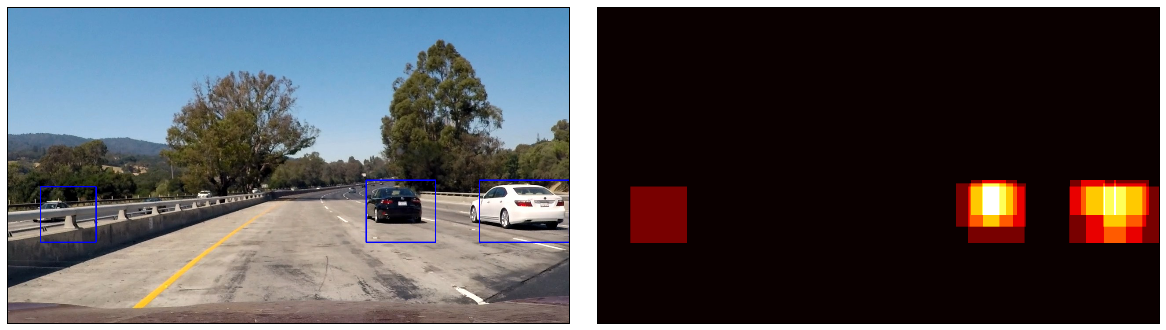

C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_depre

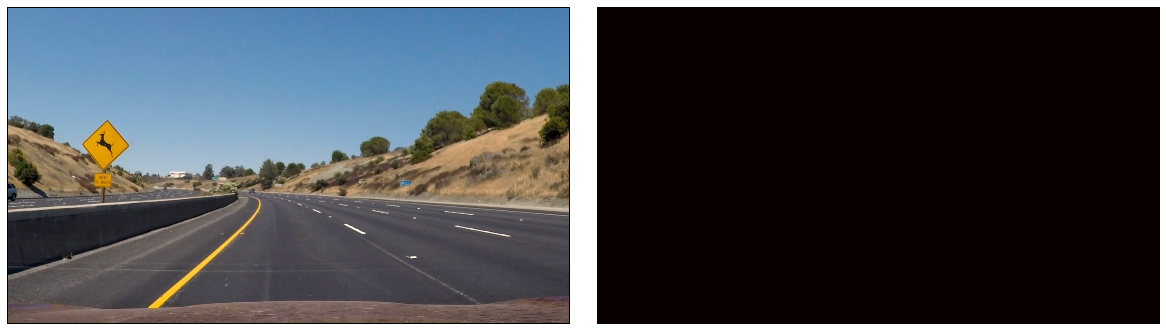

C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_depre

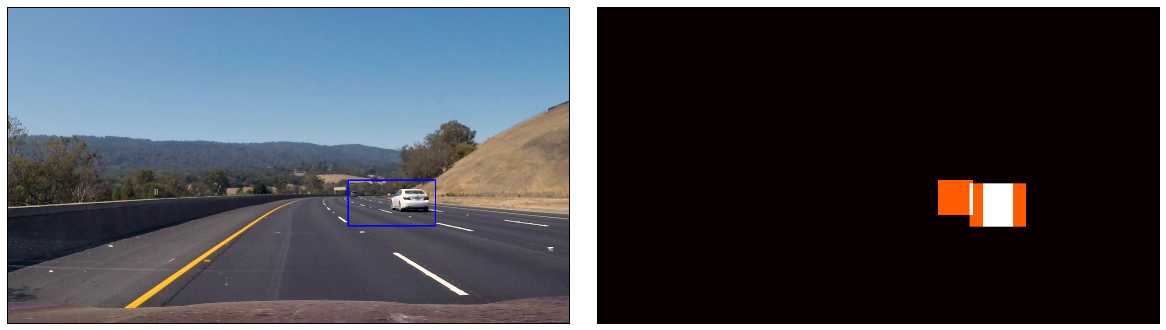

C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_depre

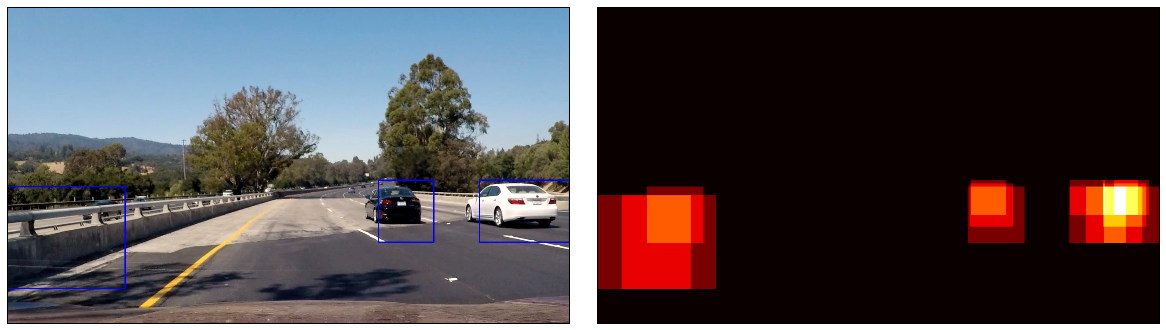

In [14]:
for image_name in glob.glob('test_images/*.jpg'):
    image = mpimg.imread(image_name)
    tracker = VehicleTracker(X_scaler, svc, image)
    tracker.process(image, draw_detections=True)

    fig = plt.figure(figsize = (16, 8))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

    axis = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
    axis.imshow(image)
    axis = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
    axis.imshow(tracker.heatmap, cmap='hot')
    plt.show()


In [ ]:
video_output_name = 'annotated_vehicles.mp4'
video = VideoFileClip("input.mp4")
tracker = VehicleTracker(X_scaler, svc, video.get_frame(0))
video_output = video.fl_image(tracker.process)
%time video_output.write_videofile(video_output_name, audio=False)

C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_depre


MoviePy: building video file annotated_vehicles.mp4
----------------------------------------

Writing video into annotated_vehicles.mp4


  0%|                                                                                         | 0/1211 [00:00<?, ?it/s]C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Program Files\Anaconda3\envs\sdgpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `bloc